In [1]:
# Install some required libraries
!pip install -e git+https://github.com/WillSH97/stable_diffusion_explainer.git@utils#egg=SDutils --upgrade

Defaulting to user installation because normal site-packages is not writeable
Obtaining SDutils from git+https://github.com/WillSH97/stable_diffusion_explainer.git@utils#egg=SDutils
  Cloning https://github.com/WillSH97/stable_diffusion_explainer.git (to revision utils) to ./src/sdutils
  Running command git clone --filter=blob:none --quiet https://github.com/WillSH97/stable_diffusion_explainer.git /mnt/c/Users/hew7/Documents/Git/stable_diffusion_explainer/SD_explainer_chapters/src/sdutils
  Running command git checkout -b utils --track origin/utils
  Switched to a new branch 'utils'
  Branch 'utils' set up to track remote branch 'utils' from 'origin'.
  Resolved https://github.com/WillSH97/stable_diffusion_explainer.git to commit fbc98344bc6bc5ebb0776d3f0719c1124408b952
  Preparing metadata (setup.py) ... done
  Running setup.py develop for SDutils


In [1]:
# Set up imports and configuration

import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
import requests
from io import BytesIO

from PIL import Image
from torchvision import transforms as tfms
import os

from SDutils import * #importing vars and funcs from previous tutorials 


/mnt/c/Users/hew7/Documents/venvs/RF-demos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# A gentle introduction to Stable Diffusion: Part 4 - Convolutional UNet de-noiser

Hello and welcome (back) to this explainer for Stable Diffusion - specifically targeting a non-technical audience. This will be a quick rundown of how *Latent Diffusion Models* (LDMs) work, specifically focusing on Stable Diffusion v1.4, as it is probably the most intuitive to explain.

This explainer will be split into multiple parts - first, we will give a high level overview of the model cascade itself, then we'll go into each component of the cascade, and finally, we'll put the model cascade together at the end!

This is the fourth section out of five: a look at the Variational Auto Encoder. The other sections are accessible [here]( https://research.qut.edu.au/genailab/projects/unboxing-genai/)

1. Introduction to Latent Diffusion Models
2. The CLiP text embedding model
3. Variational Auto Encoders for image compression
4. Convolutional UNet de-noiser
5. Conclusion - putting it all together


## Part 4: Convolutional UNet de-noiser

We now turn our attention to the core component in Stable Diffusion v1.4: the denoising algorithm. As mentioned previously, this is the heart of a Latent Diffusion model - where random noise gets reshaped into a coherent image.

There are many different model architecture approaches to denoising an image, and different LDMs will use different approaches, but in the case of Stable Diffusion v1.4, the model used is a Convolutional UNet architecture. More recent approaches are far more sophisticated, with the most popular being [Diffusion Transformers (DiT)](https://arxiv.org/pdf/2212.09748). For the sake of high level intuition though, we just have to understand that all of these models effectively do the same thing - recursively denoise latent spaces.

### What is a UNet anyway?

UNets were introduced as a new approach to biomedical image segmentation by [Ronneberger, Fischer and Brox in 2015](https://arxiv.org/pdf/1505.04597). The broad approach was to essentially take a high resolution input with a small number of "channels" (a black and white picture would be single-channel, whereas an RGB, or colour, image would have 3 - one for red, green, and blue respectively), and then through several layers of a neural network, squish that input into a low resolution latent space, with a high number of "channels", and then un-squish the image back into its original dimensional space. In a sense, you can think of these as a more general version of an [AutoEncoder]() *insert link back to tutorial once done* - in some cases, it arguably is one! You can see what that looks like below (and you can probably tell why it's called a UNet too):

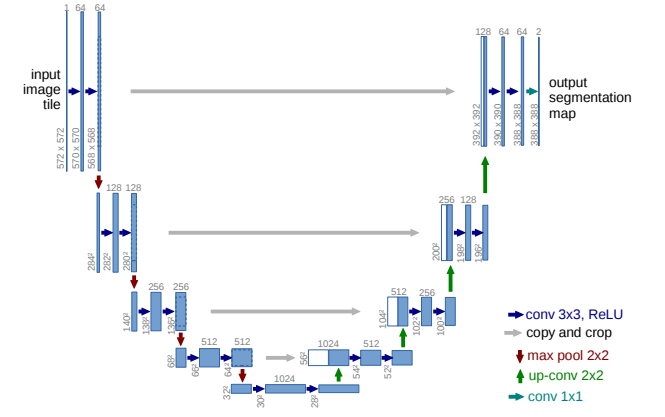

*UNet diagram from original paper*

By squishing and un-squishing, the intuition is that we can learn a lot of local "features" of the image through these channels, rather than raw pixel values, and then given these features, we can reconstruct the input image meaningfully into a more structured output. Given the skip connections as well (the arrows pointing left to right in the above image), the model is also able to use the higher-resolution inputs as a guide to what the original image looked like. The combination of both of these features is what allows a UNet to ultimately output a high resolution, structured output.

In the original implementation of the UNet, the output was fine-tuned for image segmentation. These outputs came out as the same resolution of the input, but clearly colour coding different "segments" of the image:

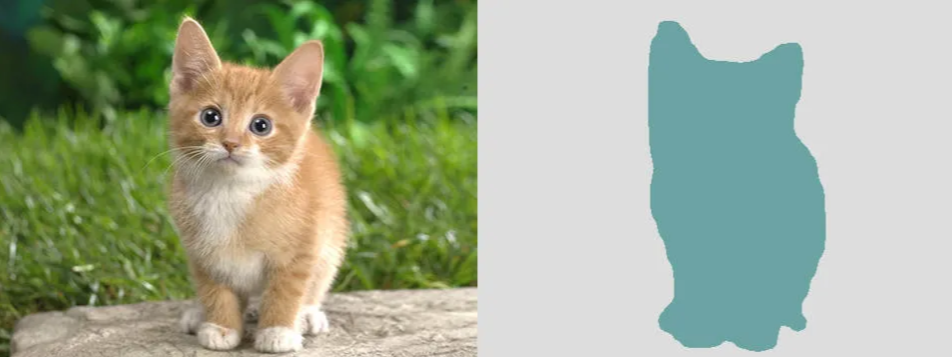

*Image segmentation example on a kitten*

This is the canonical (or most popular, well accepted) use of UNets - you're likely to have used one recently in a [Zoom meeting!](https://research.google/blog/introducing-the-next-generation-of-on-device-vision-models-mobilenetv3-and-mobilenetedgetpu/). As it so turns out though, these models were also generally pretty good at a lot of image-to-image tasks, including denoising! Specifically, given that they are so good at learning structured, meaningful features (via compressing to a low resolution, high-"channel" space at the bottom of the U), while still allowing us to upsample and output back to the original resolution of the input (via the skip connections), it's very good at predicting structure while ignoring noise, and allowing us to upsample back to the original input resolution.

With all of that out of the way, why don't we have a look at our specific UNet, finetuned to denoise our latent space:


In [2]:

# Load the model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# Halve the precision to use less memory and run faster for educational purposes
unet = unet.to(torch_device).half()


We'll also use an additional computational piece of the puzzle called a 'scheduler'. 

This is necessary because the noising process (or diffusion process) that Stability AI used to train the models was structured and "scheduled" in a particular way. Specifically, they trained their models to add a fixed amount of random noise sequentially (based on the schedule) - so if it was the 50th timestep, the scheduler would add the same amount of random noise 50 times. Then, they got their model to learn how to denoise the input based on the timestep in its "schedule". By doing so, it made the actual "diffusion" process much simpler for the model to learn. More recently, with models like [Stable Diffusion 3](https://arxiv.org/pdf/2403.03206) and [FLUX.1](https://github.com/black-forest-labs/flux), their diffusion and denoising algorithms are far more sophisticated.

For now though, we will use our linear scheduler, with a certain set of timesteps:

In [3]:
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# This is setting the number of theoretical denoising steps we're doing. This number is arbitrary - ignore it for now.
scheduler.set_timesteps(100)

# This is setting the step which we're denoising from - also ignore it for now.
demo_timestep = 80

For this demo, let's take our image of monkey Musk, embed it to the latent space, add some noise, and then ask our UNet to denoise it.

In [5]:
monkey_img, monkey_tensor, monkey_encoded_sample = generate_VAE_example_objects('https://pbs.twimg.com/media/FHCOhT4WQAEA8-6?format=jpg&name=900x900')


# Creating random noise in the same shape as our latent image data from earlier
noise = torch.randn_like(monkey_encoded_sample)

# adding the noise pattern through the scheduler
noisy_monkey_latents = scheduler.add_noise(
    monkey_encoded_sample,
    noise,
    timesteps=torch.tensor([scheduler.timesteps[demo_timestep]])
)


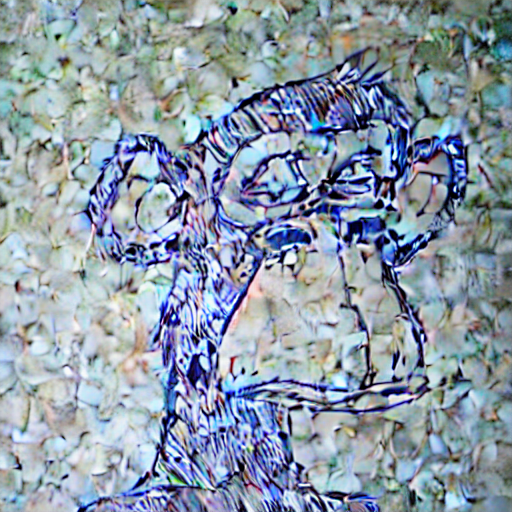

In [6]:

monkey_decoded_img_noise = VAE_decode(noisy_monkey_latents)

monkey_decoded_img_noise


Looks pretty bad huh? Well let's pass it through our UNet to denoise it.

Now we're going to have to create an empty word embedding. This is because our UNet is "conditional", so it needs a text embedding input to be conditioned on. If you pass no words in, it's effectively not "conditioned".

In [7]:

uncond_embeddings = sentence_embedder([''])[0]


We can now start denoising!

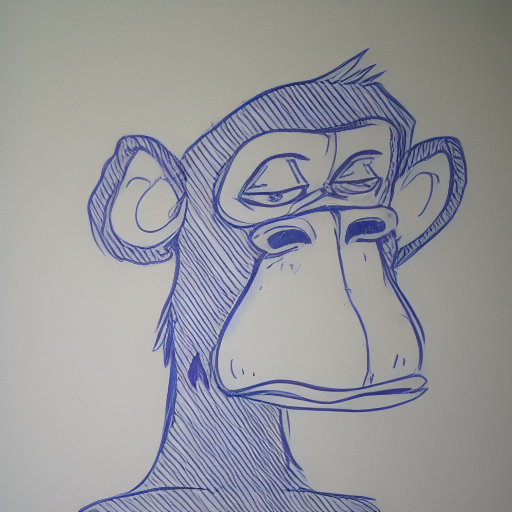

In [8]:

# Scale the latents for the unet input
latent_model_input = scheduler.scale_model_input(
    noisy_monkey_latents,
    scheduler.timesteps[demo_timestep]
).half()

# passing the scaled latent inputs to the unet, with the timestep and the unconditional embeddings
with torch.no_grad():
    noise_pred = unet(
        latent_model_input,
        scheduler.timesteps[demo_timestep],
        encoder_hidden_states=uncond_embeddings
    ).sample

# output the clean latent
clean_latents = scheduler.step(
    noise_pred,
    scheduler.timesteps[demo_timestep],
    noisy_monkey_latents
).pred_original_sample

monkey_decoded_img_denoised_PIL = VAE_decode(clean_latents)

monkey_decoded_img_denoised_PIL


Look at that! Now let's compare that to the original picture, and make a note of a few things

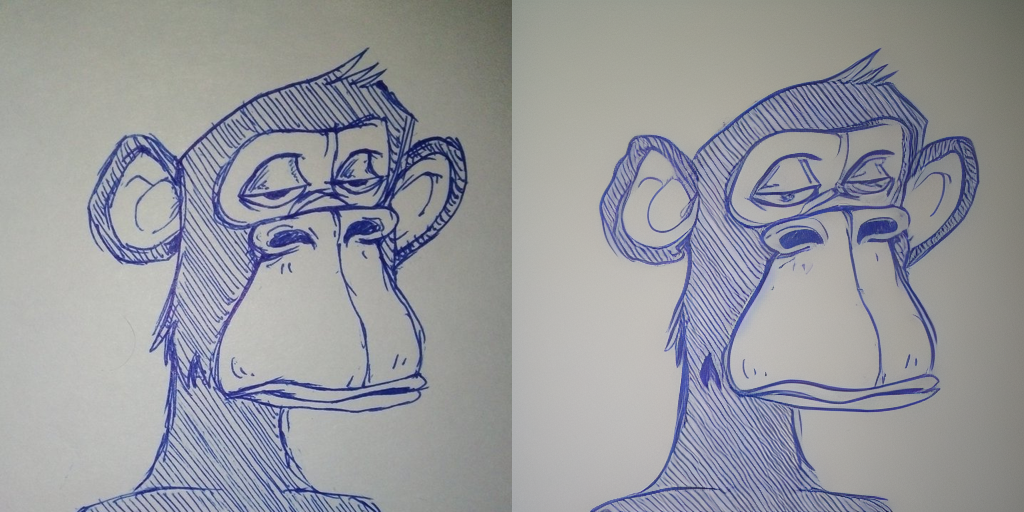

In [9]:

image_grid([monkey_img, monkey_decoded_img_denoised_PIL], 1, 2)


Our denoised image definitely looks quite clean! However, we can see that the inherent structure of monkey's face is quite different. The broad shapes/shades are there, but the overall structure is sort of more smoothed out, and cleaner. This is where iteratively denoising comes into play - when smaller amounts of noise are injected and removed, higher levels of detail are preserved through the denoising algorithm! Here, try changing the number of scheduler timesteps and demo timestep, and see what that does to the amount of noise that's input into the latents, and the similarity in denoised results of the outputs.

In [18]:
def denoising_explore(URL, num_timesteps, test_timestep):
    """
    Function which denoises input image, based on the number of scheduled timesteps set in the scheduler, as well as
    the timestep of denoising.

    e.g. If you set num_timesteps to 100, and test_timestep to 80, the noise scheduler
    will set the number of timesteps to 100, the image will be "re-noised" as if it were the 
    80th step in the diffusion process, and then "de-noised" by the Unet as if it were also the 80th timestep.

    Higher number of timesteps *should* result in smaller incremental changes between each test timestep, 
    and having a test timestep closer to the number of overall timesteps should show denoised images with more detail, 
    but have a play around!
    """
    monkey_img, monkey_tensor, monkey_encoded_sample = generate_VAE_example_objects(URL)

    
    test_timestep = test_timestep-1
    scheduler.set_timesteps(num_timesteps)
    noise = torch.randn_like(monkey_encoded_sample)
    noisy_monkey_latents = scheduler.add_noise(
        monkey_encoded_sample,
        noise,
        timesteps=torch.tensor([scheduler.timesteps[test_timestep]])
    )
    
    #scale the latents for the unet input
    latent_model_input = scheduler.scale_model_input(
        noisy_monkey_latents,
        scheduler.timesteps[test_timestep]
    ).half()
    
    # passing the scaled latent inputs to the unet, with the timestep and the unconditional embeddings
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input,
            scheduler.timesteps[test_timestep],
            encoder_hidden_states=uncond_embeddings
        ).sample
    
    # output the clean latent
    clean_latents = scheduler.step(
        noise_pred,
        scheduler.timesteps[test_timestep],
        noisy_monkey_latents
    ).pred_original_sample
    
    monkey_decoded_img_denoised_PIL = VAE_decode(clean_latents)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4)) #figsize=(16, 4)

    ax1.imshow(monkey_img)
    ax1.set_title('Original')
    ax2.imshow(monkey_decoded_img_denoised_PIL)
    ax2.set_title(f'Denoised from step {test_timestep+1} out of {num_timesteps} total steps')

    #return monkey_decoded_img_denoised_PIL


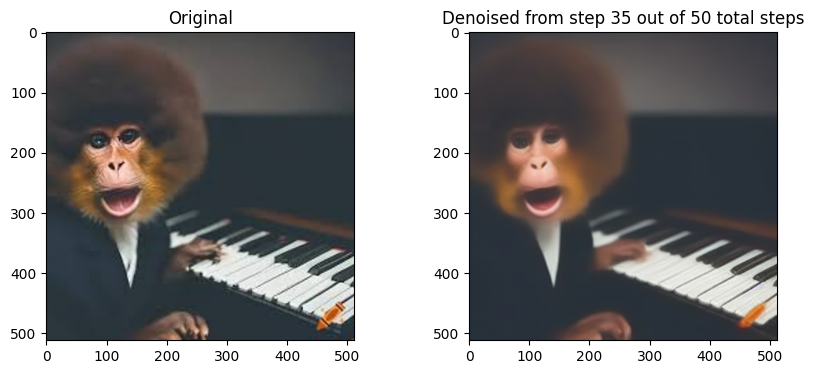

In [24]:
# ITERATE HERE
denoising_explore(URL = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSnK4vo3FXq8vnqAp9y0NWLu5BrCSF40PLvhQ&s',
                  num_timesteps=50,
                  test_timestep=35)
    

Now that we've finished looking at the UNet, we've looked at every part of the Stable Diffusion v1.4 model cascade! So we can finally put everything we've learend together in the last section of this explainer.